In [1]:
# Import PyTorch
import torch
import PIL
# We use torchvision to get our dataset and useful image transformations
import torchvision
import torchvision.transforms as transforms

# Import PyTorch's optimization libary and nn
# nn is used as the basic building block for our Network graphs
import torch.optim as optim
import torch.nn as nn

# Are we using our GPU?
print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


In [2]:
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

In [3]:
transform = {
    'train': transforms.Compose([
        # Note these are executed in the order they are called here
        # Some of these transforms return a color image, hence why we need to convert
        # the image back to grayscale
        transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
        transforms.ColorJitter(hue = .05, saturation = .05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, resample = PIL.Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
}

/home/lucien/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


In [4]:
#Getting the dataset
# Load our Training Data and specify what transform to use when loading
trainset = torchvision.datasets.CIFAR10('cifar10', 
                                      train = True, 
                                      download = True,
                                      transform = transform['train'])

# Load our Test Data and specify what transform to use when loading
testset = torchvision.datasets.CIFAR10('cifar10', 
                                     train = False,
                                     download = True,
                                     transform = transform['test'])


Files already downloaded and verified
Files already downloaded and verified


In [5]:
#Shape
print(trainset.data.shape)
print(testset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [6]:
print(trainset.data[0].shape)
print(trainset.data[0])

(32, 32, 3)
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


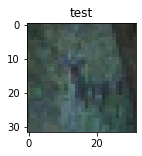

In [7]:
#Plotting an image 
import cv2
import numpy as np
from matplotlib import pyplot as plt

def imgshow(title="", image = None, size = 2):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()
    
image = trainset.data[10]
imgshow("test", image)

In [8]:
#train and test loaders 
trainloader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 512,
                                           shuffle = True,
                                           num_workers = 0)

testloader = torch.utils.data.DataLoader(testset,
                                          batch_size = 512,
                                          shuffle = False,
                                          num_workers = 0)

In [9]:
#Creating iterator for images 
dataiter = iter(trainloader)

images, labels = dataiter.next()
print(images.shape, labels.shape)

torch.Size([512, 3, 32, 32]) torch.Size([512])


In [10]:
#Shape on one image 
images[0].shape

torch.Size([3, 32, 32])

In [11]:
#Building the model 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,32,3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)

        self.dropOut = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.dropOut(x)
        
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.dropOut(x)
        
        x = self.pool(x)
        x = x.view(-1, 64*14*14)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
net = Net()
net.to(device)
    
    


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

In [12]:
print(net.parameters())

<generator object Module.parameters at 0x7fb9bd81cf20>


In [13]:
# We import our optimizer function
import torch.optim as optim

# We use Cross Entropy Loss as our loss function
criterion = nn.CrossEntropyLoss()

# For our gradient descent algorthim or Optimizer
# We use Stochastic Gradient Descent (SGD) with a learning rate of 0.001
# We set the momentum to be 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99, weight_decay = 0.001)

In [14]:
# We loop over the traing dataset multiple times (each time is called an epoch)
epochs = 50

# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# Early stopping (if loss doesn't improve for X epochs, stop)
tolerance = 10 #number of max epochs with no improvement

min_loss = 100000000000 #init to high number
n_no_impr = 0
early_stop = False
best_model = None
prev_epoch_model = None
early_stop = False
epoch = 0

# Iterate for a specified number of epochs or early stop
while(n_no_impr < tolerance and epoch < epochs):
    
        print(f'Starting Epoch: {epoch+1}...')
        # We keep adding or accumulating our loss after each mini-batch in running_loss
        running_loss = 0.0

        # We iterate through our trainloader iterator
        # Each cycle is a minibatch
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Move our data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Clear the gradients before training by setting to zero
            # Required for a fresh start
            optimizer.zero_grad()

            # Forward -> backprop + optimize
            outputs = net(inputs) # Forward Propagation 
            loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
            loss.backward() # Back propagate to obtain the new gradients for all nodes
            optimizer.step() # Update the gradients/weights

            # Print Training statistics - Epoch/Iterations/Loss/Accuracy
            running_loss += loss.item()
            if i % 25 == 24:    # show our loss every 50 mini-batches
                correct = 0 # Initialize our variable to hold the count for the correct predictions
                total = 0 # Initialize our variable to hold the count of the number of labels iterated

                # We don't need gradients for validation, so wrap in 
                # no_grad to save memory
                with torch.no_grad():
                    # Iterate through the testloader iterator
                    for data in testloader:
                        images, labels = data
                        # Move our data to GPU
                        images = images.to(device)
                        labels = labels.to(device)

                        # Foward propagate our test data batch through our model
                        outputs = net(images)

                         # Get predictions from the maximum value of the predicted output tensor
                         # we set dim = 1 as it specifies the number of dimensions to reduce
                        _, predicted = torch.max(outputs.data, dim = 1)
                        # Keep adding the label size or length to the total variable
                        total += labels.size(0)
                        # Keep a running total of the number of predictions predicted correctly
                        correct += (predicted == labels).sum().item()

                    accuracy = 100 * correct / total
                    epoch_num = epoch + 1
                    actual_loss = running_loss / 25                
                    print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                    running_loss = 0.0  

        #Early stopping
        epoch += 1
        epoch_loss = actual_loss
        print("Min loss : " + str(min_loss))
        print("Epoch loss : " + str(epoch_loss))
        
        if(epoch_loss > min_loss): #Loss increased
            n_no_impr += 1
            if(n_no_impr == 1):
                print("Saving model ...")
                torch.save(net, "best_model.pt")
            print("Loss increased for " + str(n_no_impr) + " epochs.")
        else:
            n_no_impr = 0
            min_loss = epoch_loss
            print("Loss decreased.")
        
        if(n_no_impr == tolerance):
            print("Early stopping.")
            print("Best model stored in 'best_model'.")
            best_model = torch.load("best_model.pt")
            best_model.to(device)
            early_stop = True
            break
        
        # Store training stats after each epoch
        epoch_log.append(epoch_num)
        loss_log.append(actual_loss)
        accuracy_log.append(accuracy)
else:
    if(early_stop == False):
        print("Didn't early stop.")
        print("Best model stored in 'best_model'.")
        torch.save(net, "best_model.pt")
        best_model = torch.load("best_model.pt")
        best_model.to(device)
        print("Finished Training. Model stored in 'best_model'.")

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 25, Loss: 2.263, Test Accuracy = 23.630%
Epoch: 1, Mini-Batches Completed: 50, Loss: 2.061, Test Accuracy = 32.930%
Epoch: 1, Mini-Batches Completed: 75, Loss: 1.904, Test Accuracy = 36.740%
Min loss : 100000000000
Epoch loss : 1.9035951805114746
Loss decreased.
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 25, Loss: 1.703, Test Accuracy = 41.570%
Epoch: 2, Mini-Batches Completed: 50, Loss: 1.646, Test Accuracy = 43.400%
Epoch: 2, Mini-Batches Completed: 75, Loss: 1.584, Test Accuracy = 45.780%
Min loss : 1.9035951805114746
Epoch loss : 1.5843008947372437
Loss decreased.
Starting Epoch: 3...
Epoch: 3, Mini-Batches Completed: 25, Loss: 1.518, Test Accuracy = 48.150%
Epoch: 3, Mini-Batches Completed: 50, Loss: 1.465, Test Accuracy = 48.940%
Epoch: 3, Mini-Batches Completed: 75, Loss: 1.443, Test Accuracy = 50.550%
Min loss : 1.5843008947372437
Epoch loss : 1.4428379344940185
Loss decreased.
Starting Epoch: 4...
Epoch: 4, Min

Epoch: 26, Mini-Batches Completed: 25, Loss: 0.811, Test Accuracy = 72.260%
Epoch: 26, Mini-Batches Completed: 50, Loss: 0.801, Test Accuracy = 72.770%
Epoch: 26, Mini-Batches Completed: 75, Loss: 0.803, Test Accuracy = 73.180%
Min loss : 0.8124208045005799
Epoch loss : 0.803498432636261
Loss decreased.
Starting Epoch: 27...
Epoch: 27, Mini-Batches Completed: 25, Loss: 0.799, Test Accuracy = 72.580%
Epoch: 27, Mini-Batches Completed: 50, Loss: 0.779, Test Accuracy = 73.250%
Epoch: 27, Mini-Batches Completed: 75, Loss: 0.786, Test Accuracy = 72.750%
Min loss : 0.803498432636261
Epoch loss : 0.7859558773040771
Loss decreased.
Starting Epoch: 28...
Epoch: 28, Mini-Batches Completed: 25, Loss: 0.768, Test Accuracy = 73.320%
Epoch: 28, Mini-Batches Completed: 50, Loss: 0.777, Test Accuracy = 73.490%
Epoch: 28, Mini-Batches Completed: 75, Loss: 0.776, Test Accuracy = 72.830%
Min loss : 0.7859558773040771
Epoch loss : 0.7763793754577637
Loss decreased.
Starting Epoch: 29...
Epoch: 29, Mini-Ba

Epoch: 50, Mini-Batches Completed: 75, Loss: 0.619, Test Accuracy = 76.540%
Min loss : 0.6364205431938171
Epoch loss : 0.6191772246360778
Loss decreased.
Didn't early stop.
Best model stored in 'best_model'.
Finished Training. Model stored in 'best_model'.


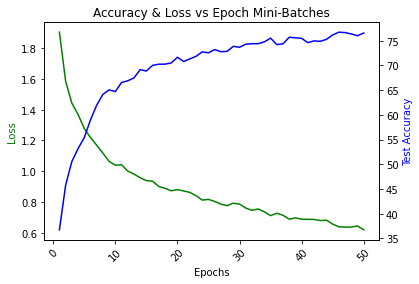

In [15]:
import matplotlib.pyplot as plt

# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

# Real accuracy of the model

In [16]:
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 76.16%
